# Open exploration

At policy0 (do nothing), run experiments with SOBOL uncertainty sampling (nr scenario = 100).

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing? *(feature scoring & sobol)*
- At timestep=0, how is each municipality influenced by the uncertainty factors? *(sobol analysis)*

*Upstream - A1 (Doesburg), A2 (Contenoever), A3 (Zutphen), A4 (Gorssel), A5 (Deventer) - Downstream*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(5) # assign problem_formulation_id

In [3]:
# with no policies
ref_policy = {'DikeIncrease': 0, 'DaysToThreat': 0, 'RfR': 0}

policy0 = {}
for key in dike_model.levers:
    _, s = key.name.split('_')
    if ' ' in s:
        s, _ = s.split(' ')
    policy0.update({key.name: ref_policy[s]})                

policy0 = Policy('Policy 0', **policy0)

In [4]:
n_scenarios = 200

In [5]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios= n_scenarios,
                                            policies = policy0,
                                            uncertainty_sampling='sobol')

save_results(results, './results/sobol_policy0_200Scenarios_fullyDisaggregated.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 8000 scenarios * 1 policies * 1 model(s) = 8000 experiments
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 5600 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\epa1361_open\final assignment\results\sobol_policy0_200Scenarios_fullyDisaggregated.tar.gz


Wall time: 1h 18min 39s


In [65]:
results = load_results(r'./results/sobol_policy0_200Scenarios_fullyDisaggregated.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\epa1361_open\final assignment\results\sobol_policy0_200Scenarios_fullyDisaggregated.tar.gz


In [62]:
# subset only the uncertainties
uncertainties = experiments.filter(regex=r'(wave shape$|Bmax$|pfail$|Brate$|^discount)')

uncertainties.sample(10)

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
6253,51.0,136.71875,1.5,0.678223,42.03125,1.0,0.503418,121.71875,1.0,0.854980,209.21875,1.0,0.868652,59.53125,1.0,0.970215,1.5,2.5,2.5
3866,129.0,30.46875,1.0,0.927246,83.59375,1.0,0.905762,325.78125,1.5,0.854004,306.40625,1.5,0.911621,88.59375,1.5,0.626465,1.5,2.5,3.5
3878,129.0,30.46875,1.0,0.927246,83.59375,1.0,0.998535,325.78125,1.5,0.854004,306.40625,1.5,0.911621,88.59375,1.5,0.626465,1.5,2.5,1.5
4589,92.0,340.46875,1.0,0.208496,333.59375,1.5,0.092285,195.78125,1.5,0.054199,116.40625,1.5,0.942871,178.59375,1.5,0.095215,2.5,2.5,3.5
5100,21.0,195.46875,1.0,0.067871,108.59375,1.0,0.451660,330.78125,1.0,0.682129,331.40625,1.5,0.364746,313.59375,1.5,0.173340,1.5,3.5,3.5
3552,87.0,90.46875,1.5,0.864746,303.59375,1.0,0.936035,185.78125,1.5,0.416504,86.40625,1.5,0.854980,108.59375,1.0,0.188965,1.5,1.5,1.5
1720,45.0,300.46875,1.5,0.080566,198.28125,1.0,0.460449,47.96875,1.5,0.765137,202.96875,1.5,0.862793,108.28125,1.0,0.075684,1.5,2.5,1.5
100,128.0,277.18750,1.0,0.700195,282.81250,1.5,0.157227,122.81250,1.0,0.309570,219.06250,1.0,0.395508,44.68750,1.0,0.051758,1.5,2.5,2.5
5603,58.0,142.96875,1.5,0.432129,75.78125,1.5,0.702637,95.46875,1.0,0.194824,265.46875,1.0,0.401855,75.78125,1.0,0.677246,3.5,1.5,2.5
2123,103.0,240.46875,1.5,0.768066,258.28125,1.5,0.147949,307.96875,1.0,0.952637,62.96875,1.0,0.050293,88.28125,1.0,0.263184,1.5,1.5,3.5


## Feature scoring

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing?

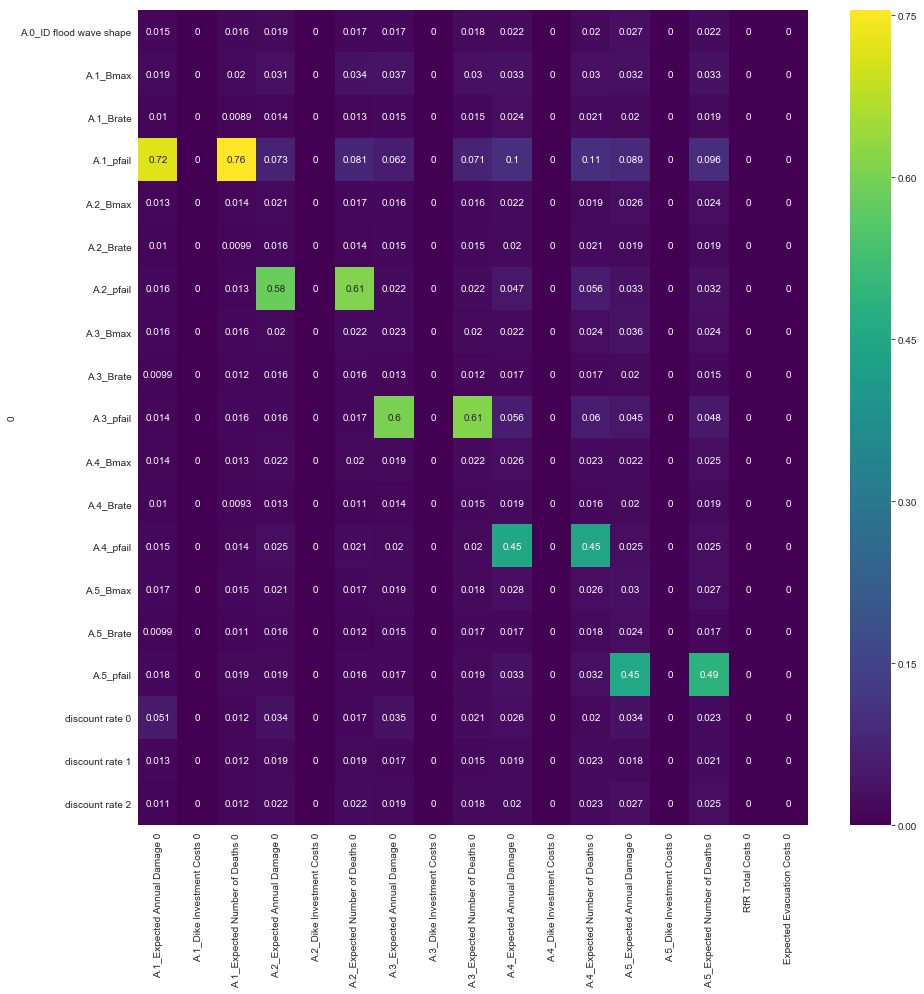

In [8]:
# plot feature scoring at timestep=0
x = uncertainties
y = pd.DataFrame.from_dict(outcomes).filter(regex=r'0$') # subset only timestep=1

fs = feature_scoring.get_feature_scores_all(x, y)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(fs, cmap='viridis', annot=True)

## Sobol

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing?
- At timestep=0, how is each municipality influenced by the uncertainty factors? 

In [9]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

problem = get_SALib_problem(dike_model.uncertainties)

In [60]:
def plot_per_municipality_timestep0(KPI):
    # plot assigned outcome KPI for all five municipalities
    fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True)
    fig.suptitle('Sobol score: Uncertainties on {} at timestep=0 per municipality'.format(KPI),
                 fontsize = 'x-large', y=0.93)

    for i in range(0, 5):
        KPI_i = 'A.{}_{} 0'.format(i+1, KPI) # assign the outcome kpi in interest

        Si = sobol.analyze(problem, outcomes[KPI_i], 
                           calc_second_order=True, print_to_console=False)

        Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter, index=problem['names'])

        indices = Si_df[['S1','ST']]
        err = Si_df[['S1_conf','ST_conf']]

        indices.plot.bar(yerr=err.values.T, ax=axes[i], figsize=(12, 8), grid=True)
        axes[i].set_ylabel('A.{}'.format(i+1),
                           fontsize = 'large')
    fig.align_ylabels()

In [55]:
def plot_pfail_per_municipality_timestep0(KPI):
    # plot assigned outcome KPI for all five municipalities, looking only at pfail
    fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True)
    fig.suptitle('Sobol score: pfail on {} at timestep=0 per municipality'.format(KPI),
                 fontsize = 'x-large', y=0.93)

    for i in range(0, 5):
        KPI_i = 'A.{}_{} 0'.format(i+1, KPI) # assign the outcome kpi in interest

        Si = sobol.analyze(problem, outcomes[KPI_i], 
                           calc_second_order=True, print_to_console=False)

        Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter, index=problem['names']).filter(regex='pfail$', axis=0)

        indices = Si_df[['S1','ST']]
        err = Si_df[['S1_conf','ST_conf']]

        indices.plot.bar(yerr=err.values.T, ax=axes[i], figsize=(8, 8), grid=True)
        axes[i].set_ylabel('A.{}'.format(i+1),
                           fontsize = 'large')
    fig.align_ylabels()

### Expected Annual Damage

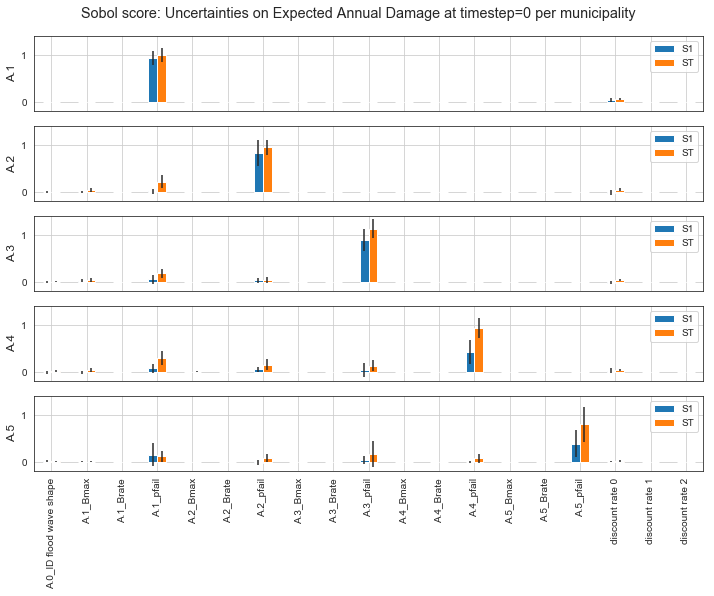

In [61]:
# plot `Expected Annual Damage` at timestep=0 for all five municipalities
plot_per_municipality_timestep0('Expected Annual Damage')

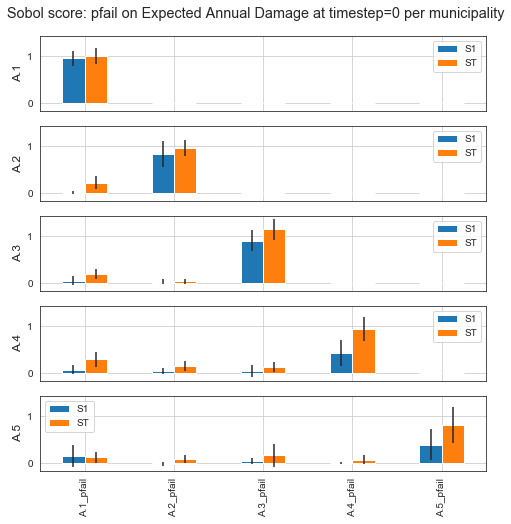

In [56]:
# subset only pfail
plot_pfail_per_municipality_timestep0('Expected Annual Damage')

### Expected Number of Death

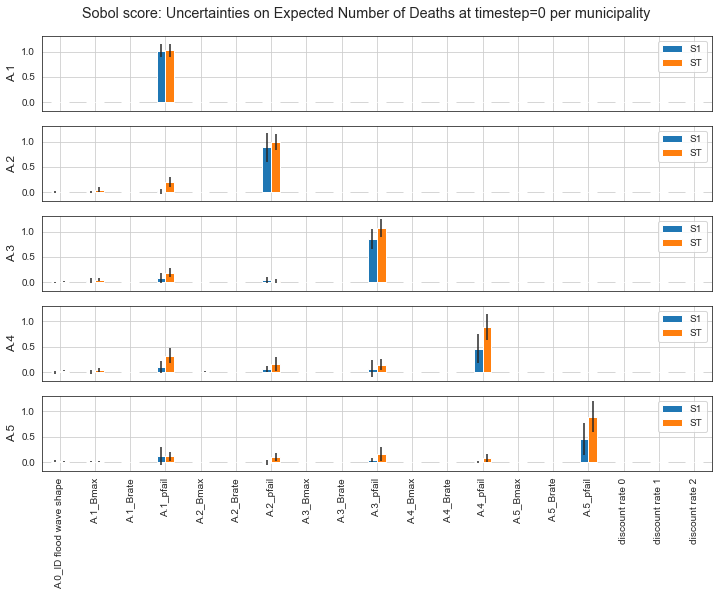

In [45]:
# plot `Expected Number of Deaths` at timestep=0 for all five municipalities
plot_per_municipality_timestep0('Expected Number of Deaths')

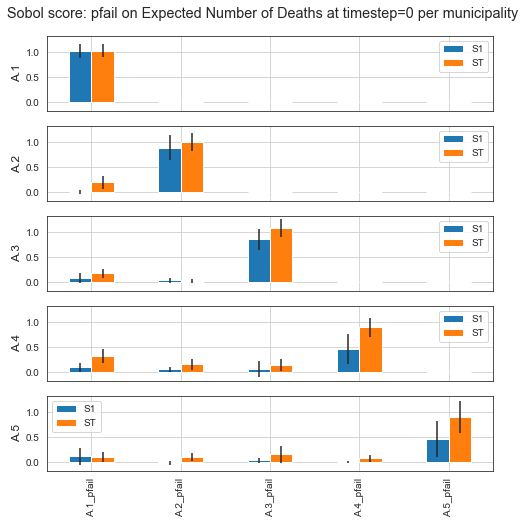

In [57]:
# subset only pfail
plot_pfail_per_municipality_timestep0('Expected Number of Deaths')